$$ RETI \  NEURALI  $$

Vogliamo costruire una rete neurale che sia una combinazione di strati Convolutional e Recurrent.

Per usare questo approccio abbiamo bisogno che gli input siano immagini. A tale scopo abbiamo convertito ogni traccia audio in uno spettrogramma.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from os import listdir
import librosa
import librosa.display

import numpy as np
import pandas as pd

import sklearn.preprocessing as prep
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm


plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

In [3]:
track_df = pd.read_csv(
    "../data/fma_metadata/tracks.csv", index_col=False
)  # Carico il file tracks.csv
col = track_df.iloc[0] 
col[0] = "track_id"
track_df.columns = col
track_df = track_df.iloc[2:]
# Seleziono solo le canzoni del sottoinsieme small (saranno 8000 su 106574)
small_df=track_df[track_df['subset']=="small"] 
# Seleziono solo le colonne track_id e genre_top
small_df=small_df[["track_id", "genre_top"]] 
small_df.reset_index(drop=True, inplace=True) 
small_df['track_id'] = small_df['track_id'].astype(str) 
small_df.shape

(8000, 2)

$$ SPETTROGRAMMI  $$

Uno spettrogramma è la rappresentazione grafica dell'intensità di un suono in funzione del tempo e della frequenza o, in altre parole, è la rappresentazione grafica della funzione a valori reali $\textit i(t,f) $.

Benché sia evidentemente possibile rappresentare la funzione $\textit i(t,f) $ come una superficie (su un diagramma cartesiano con assi t, f ed i), di solito per gli spettrogrammi si usa un'altra rappresentazione grafica, nella quale:

   - sull'asse delle ascisse è riportato il tempo in scala lineare.
   
   - sull'asse delle ordinate è riportata la frequenza in scala lineare o logaritmica.
   
   - a ciascun punto di data ascissa e data ordinata è assegnata una tonalità di grigio, o un colore, rappresentante l'intensità del suono in un dato istante di tempo e a una data frequenza; la relazione fra l'intensità del suono e la scala di grigi o di colori può essere lineare o logaritmica.

Abbiamo usato la funzione già implementata in librosa $\textit librosa.feature.melspectrogram() $ per convertire ogni segnale audio in uno spettrogramma  di dimensione 640x128.

Nelle figure seguenti sono mostrati gli spettrogrammi per ogni genere. 

Notiamo dalle immagini che alcuni di essi sono molto diversi fra loro.

Invece per altre classi, come Pop e Electronic, lo spettrogramma risulta simile.

Come vedremo la rete neurale tenderà a confonderli.

In [4]:
Folk, sr = librosa.load("../data/samples/002097.mp3")
Rock, sr = librosa.load("../data/samples/002012.mp3")
International, sr = librosa.load("../data/samples/001684.mp3")
Experimental, sr = librosa.load("../data/samples/145058.mp3")
Hip_Hop, sr = librosa.load("../data/samples/000005.mp3") 
Pop, sr = librosa.load("../data/samples/148587.mp3") 
Electronic, sr = librosa.load("../data/samples/001075.mp3")
Instrumental, sr = librosa.load("../data/samples/010250.mp3")

genres_List = ["Folk", "Rock", "International", "Experimental", "Hip-Hop", "Pop", "Electronic", "Instrumental"]
genres = [Folk, Rock, International, Experimental, Hip_Hop, Pop, Electronic, Instrumental]

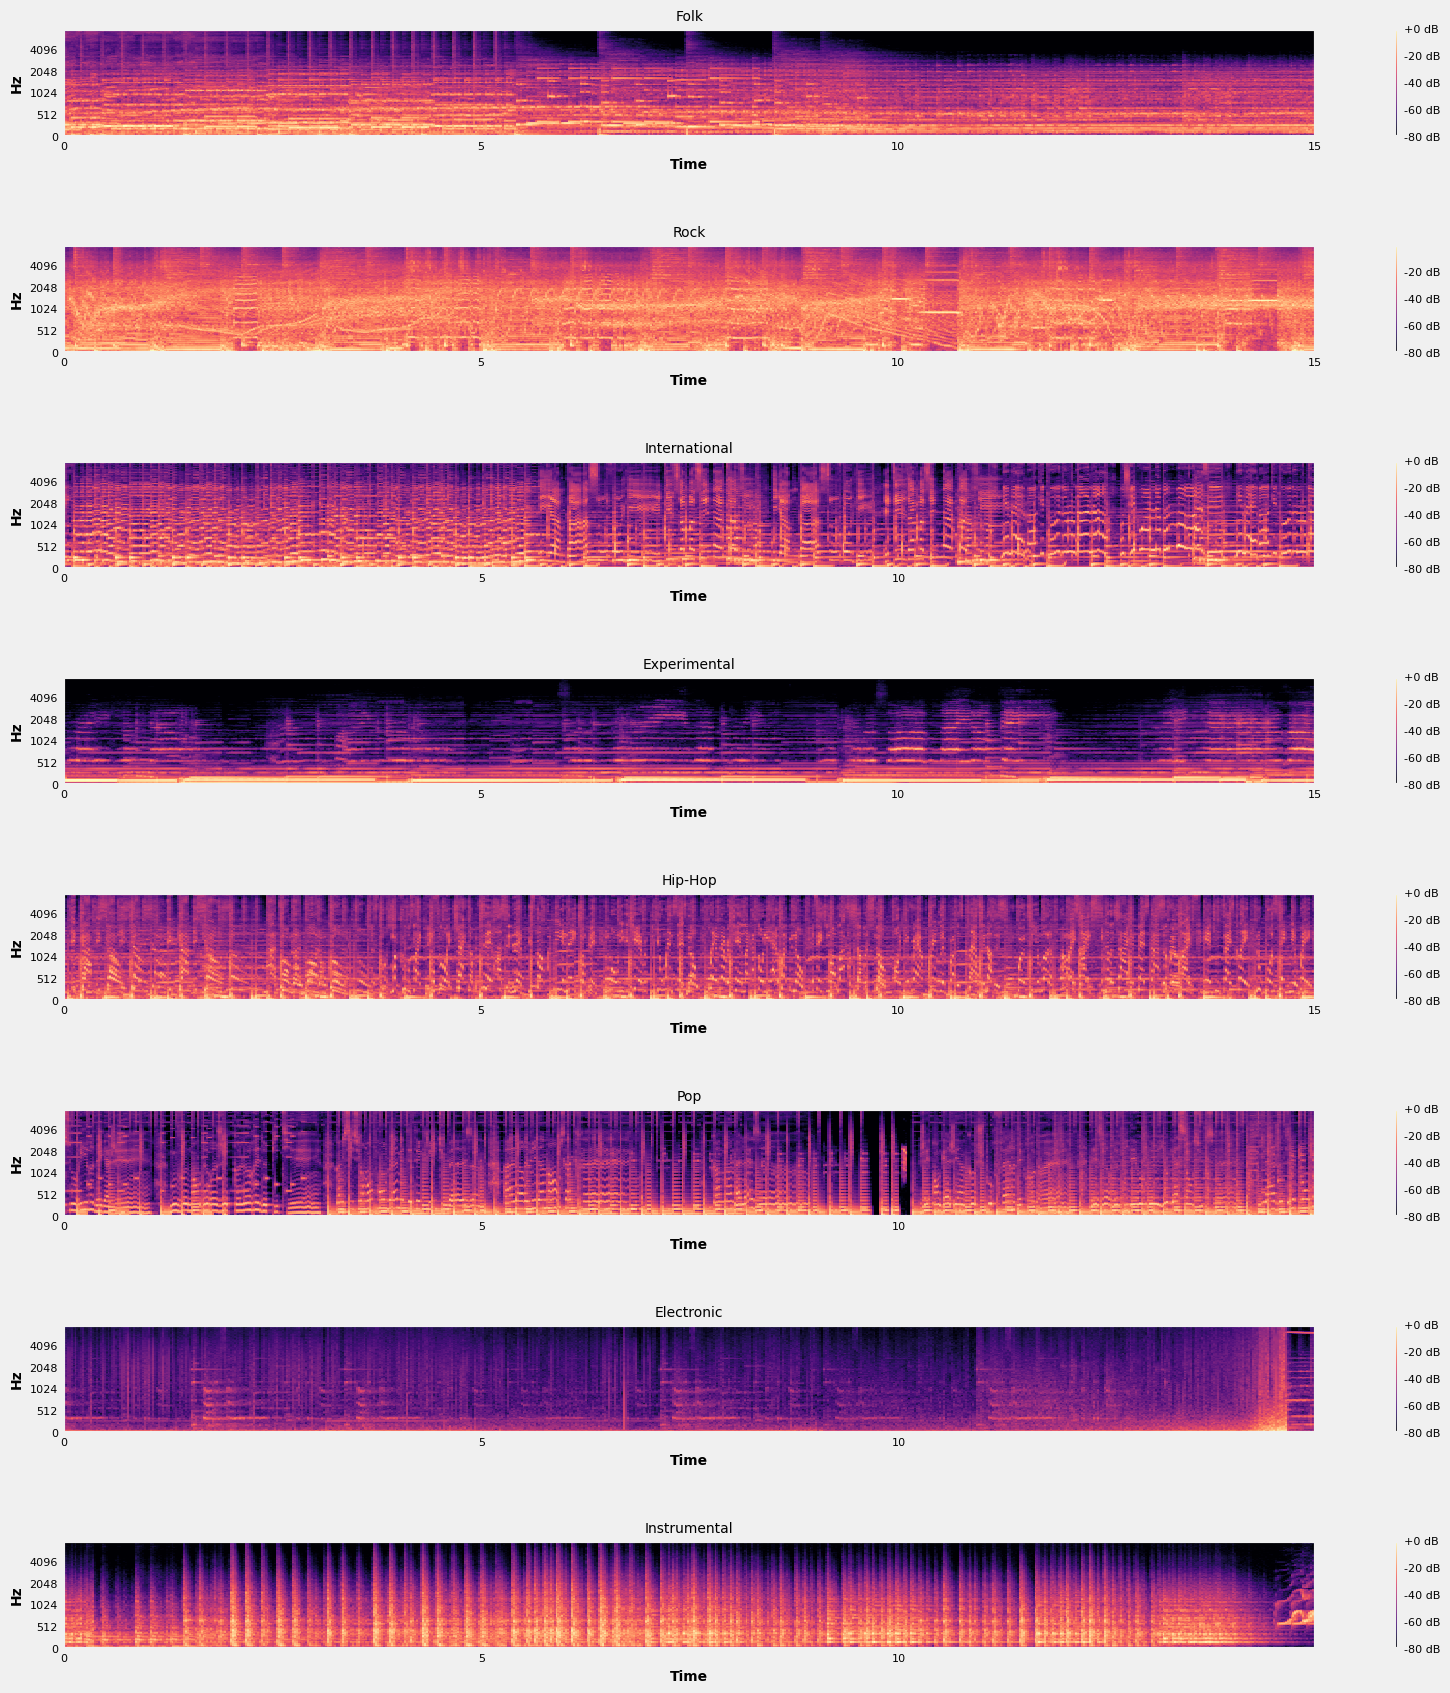

In [5]:
plt.figure(figsize=(18, 20))

i=1

for x in genres:

    plt.subplot(8, 1, i)
    plt.subplots_adjust(hspace = 1 )
    spect = librosa.feature.melspectrogram(y=x, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.T
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(genres_List[i-1])
    i=i+1


In [6]:

# def load_features(song_per_genre):
#     genre_count = { 'Hip-Hop' : 0, 'Pop' : 0, 'Experimental' : 0, 'Rock' : 0, 
#                'International' : 0, 'Electronic' : 0, 'Instrumental' : 0 , 'Folk' : 0 }
        
#     # lista di tutte le cartelle con le canzoni    
#     all_folders = listdir("../data/fma_small/")[:-2]

    
#     genres = []
#     X_spect = np.empty((0, 640, 128))
                       
#     dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
#                'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }
#     # Scorriamo tutte le canzoni in tutte le cartelle:
#     for fold in all_folders: 
#         for song in listdir("../data/fma_small/" + fold):
                
#             try:
                
#                 # in current_track immagazzino il track_id con le seguenti operazioni:
#                 # -) il -4 è per eliminare il ".mp3"
#                 # -) int per eliminare gli zeri 
#                 # -) str per convertirlo in stringa
#                 current_track = str(int(song[:-4])) 
#                 #Salvo il genere rispetto a quel track_id
#                 current_genre = small_df[small_df["track_id"]==current_track].iloc[0,1]

#                 # Se non ci sono abbatanza canzoni per quel genere va avanti (altrimenti skippa)
#                 if genre_count[current_genre]>=song_per_genre: 
#                     # Se ci sono abbastanza per ogni genere ritorna il dataframe di Spettrogrammi
#                     if min(genre_count.values()) == song_per_genre:
#                         y_arr = np.array(genres)
#                         return X_spect, y_arr
#                     else: 
#                         continue
             
#                 # Load an audio file as a floating point time series  
#                 x, sr = librosa.load("../data/fma_small/" + fold + "/" + song)
                
#                 # hop_length indica il numero di campioni in comune tra un frame ed il successivo
#                 # n_fft indica la lunghezza delle Fast Fourier Transform
#                 spect = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=2048, hop_length=1024)
#                 spect = librosa.power_to_db(spect, ref=np.max)
#                 spect = spect.T

#                 spect = spect[:640, :]
#                 X_spect = np.append(X_spect, [spect], axis=0)

#                 genres.append(dict_genres[current_genre])

#                 genre_count[current_genre] += 1

#                 clear_output()
#                 display(genre_count)
                
#             except Exception as e:
#                 print("ERRORE QUA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", e, fold, song)

In [6]:
def load_features(song_per_genre):
    genre_count = {
        "Hip-Hop": 0,
        "Pop": 0,
        "Experimental": 0,
        "Rock": 0,
        "International": 0,
        "Electronic": 0,
        "Instrumental": 0,
        "Folk": 0,
    }

    # List of all folders with songs
    all_folders = listdir("../data/fma_small/")[:-2]

    genres = []
    X_spect = np.empty((0, 640, 128))

    dict_genres = {
        "Electronic": 1,
        "Experimental": 2,
        "Folk": 3,
        "Hip-Hop": 4,
        "Instrumental": 5,
        "International": 6,
        "Pop": 7,
        "Rock": 8,
    }

    # Iterate over all folders
    for fold in all_folders:
        for song in listdir("../data/fma_small/" + fold):
            try:
                # Extract track_id from the file name
                current_track = str(int(song[:-4]))

                # Get the genre for the current track
                current_genre = small_df[small_df["track_id"] == current_track].iloc[
                    0, 1
                ]

                # Skip if the genre has enough songs
                if genre_count[current_genre] >= song_per_genre:
                    # Check if all genres have enough songs
                    if min(genre_count.values()) == song_per_genre:
                        y_arr = np.array(genres)
                        return X_spect, y_arr
                    else:
                        continue

                # Load the audio file
                x, sr = librosa.load("../data/fma_small/" + fold + "/" + song)

                # Compute the spectrogram
                spect = librosa.feature.melspectrogram(
                    y=x, sr=sr, n_fft=2048, hop_length=1024
                )
                spect = librosa.power_to_db(spect, ref=np.max)
                spect = spect.T

                # Ensure spectrogram shape is correct
                spect = spect[:640, :]
                X_spect = np.append(X_spect, [spect], axis=0)

                # Append genre and increment count
                genres.append(dict_genres[current_genre])
                genre_count[current_genre] += 1

                # Display progress
                clear_output()
                display(genre_count)

            except Exception as e:
                print("Error:", e, fold, song)

    # Ensure the function always returns valid data
    y_arr = np.array(genres)
    return X_spect, y_arr

In [7]:
X_spect, y_arr = load_features(1000)

{'Hip-Hop': 997,
 'Pop': 1000,
 'Experimental': 999,
 'Rock': 999,
 'International': 1000,
 'Electronic': 999,
 'Instrumental': 1000,
 'Folk': 1000}

In [8]:
# SPLIT
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X_spect, y_arr, stratify=y_arr, 
                                                    shuffle=True , test_size=0.1,random_state=0)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_temp, Y_train_temp, stratify=Y_train_temp, 
                                                    shuffle=True , test_size=0.1112, random_state=0)


In [9]:
print('Train:', X_train.shape, Y_train.shape)
print('Test:', X_test.shape, Y_test.shape)
print('Validation:', X_valid.shape, Y_valid.shape)

Train: (6394, 640, 128) (6394,)
Test: (800, 640, 128) (800,)
Validation: (800, 640, 128) (800,)


In [10]:
# conversione scala logaritmica
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
X_train = np.log(X_train_raw)

X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid = np.log(X_valid_raw)

# Facciamo la Codifica 1 of K dei target perchè useremo la Loss Categorical Cross Entropy
# come metrica nella nostra rete neurale
binarizer = prep.LabelBinarizer()

binarizer.fit(Y_train)
Y_train = binarizer.transform(Y_train)
Y_valid = binarizer.transform(Y_valid)

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)
print("Validation:", X_valid.shape, Y_valid.shape)

# salviamo
np.savez("../data/shuffled_train", X_train, Y_train)
np.savez("../data/shuffled_valid", X_valid, Y_valid)
np.savez("../data/test_arr", X_test, Y_test)

Train: (6394, 640, 128) (6394, 8)
Test: (800, 640, 128) (800,)
Validation: (800, 640, 128) (800, 8)
